# Workshop - Exploratory Data Analysis

In this workshop, we will work with a dataset of thermochemical data for some molecules to explore what features or descriptors are influential in their melting and/or boiling points. 

## Useful resources

We will be using some of the python libraries you have already seen and Seaborn, which you might not have yet. Here are some quick start guides and/or tutorials that might come in useful.

- Pandas
  - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
- Matplotlib
  - [Quick start guide](https://matplotlib.org/stable/users/explain/quick_start.html)
- RDKit
  - [Getting started with the RDKit in Python](https://www.rdkit.org/docs/GettingStartedInPython.html)
  - [RDKit tutorial from 2021](https://github.com/greglandrum/AIDD_RDKit_Tutorial_2021/blob/b4c4661ff7980721823654f54cd0c28031c5884c/RDKit_Intro.ipynb) - this covers a lot of ground. We won't be talking about reactions (towards end of notebook)
  - There are also lots of videos on YouTube and of course ChatGPT (though I am not sure how well it does with RDKit, probably because the documentation is patchy).


You might also find some useful bits and pieces in the [Molecular fingerprints notebook](https://drsamchong.github.io/c3d-book/1-chem_data/fingerprints.html) in the module book.




## Visualising factors affecting thermochemical properties <br/> of organic compounds

Let's start by importing some libraries:

- time (needed to include a sleep)
- requests
- pandas 
- numpy
- matplotlib
- seaborn

In [219]:
# TODO: Write your import statements here.

import requests
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# rdkit has a complicated structure, so we will start with these and maybe add some later

from rdkit import Chem
from rdkit.Chem import (
                        AllChem,
                        rdCoordGen,
                        Draw,
                        rdFingerprintGenerator,
                        PandasTools,
                        Descriptors
                        )

from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs

from IPython.display import SVG
from ipywidgets import interact,fixed,IntSlider

### Loading the data

The data is stored in a flat csv file in the `data` directory called `alcohol_acid_phys_data.csv`.



In [220]:
# TODO:

# 0. Check the data in the file (try the 'head' command)
# 1. Read the data into a pandas dataframe
# 2. Display the dataframe



In [221]:
# 0. Check the data in the file (try the 'head' command)

!head data/alcohol_acid_phys_data.csv

Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,pKa(1),pKa(2)
1-alkanol,Methanol,Methyl alcohol,1,4,1,32.04,-98,65,0.791,15.5,
1-alkanol,Ethanol,Ethyl alcohol,2,6,1,46.07,-114,78,0.789,15.5,
1-alkanol,1-Propanol,Propyl alcohol,3,8,1,60.09,-124,97,0.804,16.1,
1-alkanol,1-Butanol,Butyl alcohol,4,10,1,74.12,-89,118,0.81,16.1,
1-alkanol,1-Pentanol,Amyl alcohol,5,12,1,88.15,-78,138,0.814,,
1-alkanol,1-Hexanol,Caproyl alcohol,6,14,1,102.17,-46,157,0.814,,
1-alkanol,1-Heptanol,Heptyl alcohol,7,16,1,116.198,-33,178,0.822,,
1-alkanol,1-Octanol,Capryl alcohol,8,18,1,130.22,-15,195,0.829,,
1-alkanol,1-Nonanol,Nonyl alcohol,9,20,1,144.25,-5,214,0.828,,


In [222]:
# 1. Read the data into a pandas dataframe

compounds_df = pd.read_csv('data/alcohol_acid_phys_data.csv')

# 2. Display the dataframe

compounds_df

,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,pKa(1),pKa(2)
0,1-alkanol,Methanol,Methyl alcohol,1,4,1,32.04,-98,65,0.791,15.50,NaN
1,1-alkanol,Ethanol,Ethyl alcohol,2,6,1,46.07,-114,78,0.789,15.50,NaN
2,1-alkanol,1-Propanol,Propyl alcohol,3,8,1,60.09,-124,97,0.804,16.10,NaN
3,1-alkanol,1-Butanol,Butyl alcohol,4,10,1,74.12,-89,118,0.810,16.10,NaN
4,1-alkanol,1-Pentanol,Amyl alcohol,5,12,1,88.15,-78,138,0.814,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
120,Branched\r\ndioic acids,3-Methylpentanedioic\r\nacid,3-Methylglutaric acid,6,10,4,146.14,83,NaN,NaN,4.24,NaN
121,Aromatic\r\ndioic acids,"1,2-Benzenedicarboxylic\r\nacid",o-Phthalic acid,8,6,4,166.13,d210,NaN,NaN,4.42,5.41
122,Aromatic\r\ndioic acids,"2,6-\r\nNaphthalenedicarboxylic\r\nacid",NaN,12,8,4,216.18,>300,NaN,NaN,NaN,NaN
123,Aromatic\r\ndioic acids,"1,4-\r\nNaphthalenedicarboxylic\r\nacid",NaN,12,8,4,216.18,>301,NaN,NaN,NaN,NaN


### Cleaning the data

We need to do at least a little cleaning of the data. We can check the data for the number of rows and the data types in each column using [`DataFrame.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method.

In [223]:
compounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            125 non-null    object 
 1   IUPAC name       125 non-null    object 
 2   Common name      86 non-null     object 
 3   #C               125 non-null    int64  
 4   #H               125 non-null    int64  
 5   #O               125 non-null    int64  
 6   Molweight g/mol  123 non-null    float64
 7   mp / °C          114 non-null    object 
 8   bp / °C          107 non-null    object 
 9   density / g/ml   98 non-null     float64
 10  pKa(1)           72 non-null     float64
 11  pKa(2)           19 non-null     float64
dtypes: float64(4), int64(3), object(5)
memory usage: 11.8+ KB


There are lots of pKa values missing. We are not going to use the pKa values, so we can drop those columns.

Some rows are missing densities. And more importantly, some are missing melting and/or boiling points, which is the property we are interested in.

It might be possible to look these up somewhere, like the [NIST Chemistry WebBook](https://webbook.nist.gov/chemistry/) which unfortunately does seem not have a convenient API (there are unofficial ones if you search on the web). For now we can also drop these rows.


In [224]:
# TODO:
# 1. Drop the two pKa columns
# 2. Drop the rows with NaN values in density, melting point and boiling point columns.
# 3. Check the info again to see if the changes have been made.


In [225]:
# 1. Drop the two pKa columns

cdf = compounds_df.drop(columns=["pKa(1)", "pKa(2)"])

# You can check where there are still any NaN values are in the dataframe using the following command.
# It filters the df to show the rows with NaN values in any column (axis=1).
cdf[cdf.isnull().any(axis=1)]


,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
12,1-alkanol,1-Tridecanol,NaN,13,28,1,200.35,31,287,0.822
14,1-alkanol,1-Pentadecanol,NaN,15,32,1,228.41,44,318,0.835
15,1-alkanol,1-Docosanol,NaN,22,46,1,326.59,71,NaN,NaN
19,2-alkanol,2-hexanol,NaN,6,14,1,102.17,-23,138,0.816
20,2-alkanol,2-heptanol,NaN,7,16,1,116.20,NaN,159,0.817
22,2-alkanol,2-Nonanol,NaN,9,20,1,144.25,-35,194,0.830
23,2-alkanol,2-Decanol,NaN,10,22,1,158.28,-5,212,0.825
24,2-alkanol,2-Dodecanol,NaN,12,26,1,186.33,19,249,0.829
26,3-alkanol,3-Hexanol,NaN,6,14,1,102.17,-57,143,0.818
28,3-alkanol,3-Octanol,NaN,8,18,1,130.22,-45,175,0.826


In [226]:
# 2. Drop the rows with NaN values in density, melting point and boiling point columns.
# Using the subset parameter in the dropna function, you can specify the columns to 
# look for NaN values.

cdf = cdf.dropna(subset=["density / g/ml", "mp / °C", "bp / °C"])

In [227]:
# 3. Check the info again to see if the changes have been made.

display(cdf.info())
cdf[cdf.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 116
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            85 non-null     object 
 1   IUPAC name       85 non-null     object 
 2   Common name      65 non-null     object 
 3   #C               85 non-null     int64  
 4   #H               85 non-null     int64  
 5   #O               85 non-null     int64  
 6   Molweight g/mol  85 non-null     float64
 7   mp / °C          85 non-null     object 
 8   bp / °C          85 non-null     object 
 9   density / g/ml   85 non-null     float64
dtypes: float64(2), int64(3), object(5)
memory usage: 7.3+ KB


None

,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
12,1-alkanol,1-Tridecanol,NaN,13,28,1,200.35,31,287,0.822
14,1-alkanol,1-Pentadecanol,NaN,15,32,1,228.41,44,318,0.835
19,2-alkanol,2-hexanol,NaN,6,14,1,102.17,-23,138,0.816
22,2-alkanol,2-Nonanol,NaN,9,20,1,144.25,-35,194,0.830
23,2-alkanol,2-Decanol,NaN,10,22,1,158.28,-5,212,0.825
24,2-alkanol,2-Dodecanol,NaN,12,26,1,186.33,19,249,0.829
26,3-alkanol,3-Hexanol,NaN,6,14,1,102.17,-57,143,0.818
28,3-alkanol,3-Octanol,NaN,8,18,1,130.22,-45,175,0.826
29,3-alkanol,3-Nonanol,NaN,9,20,1,144.25,22,193,0.825
30,3-alkanol,3-Decanol,NaN,10,22,1,158.28,-5,212,0.827


Still a few issues (from looking at the dataframe and its info):

- The `Class` and `IUPAC name` columns have some odd characters which appear to encode whitespace, e.g. "Alkanedioic\r\nacid" contains "\r\n" characters.
- The `DataFrame.info()` shows that the melting and boiling points have `object`, i.e. string data, types, which suggests there are non-numerical values. If you look at the columns, some rows have "d" or "s" sometimes with a number (e.g. trans-Butenedioic acid), probably to denote "decomposed" or "sublimed" maybe.


Pandas has `str.contains` and `str.replace` methods for its `Series` structure. Try using these to check and remove the encoded characters in the columns.

Can you think of a way to deal with the non- or partly numeric phase change values?

:::{hint}
Could [this](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) help?
:::


In [228]:
# TODO:

# 1. Ensure only numeric values are present in the melting point, boiling point columns
# 2. Remove the encoded whitespace characters from the 'Class' and 'IUPAC name' columns
# 3. Convert the melting point, boiling point columns to numeric values.

In [229]:
# 1. Ensure only numeric values are present in the melting point, boiling point columns

# pd.to_numeric with errors='coerce' will convert non-numeric values to NaN - makes it straightforward
# to be dropped later

cdf["mp / °C"] = pd.to_numeric(cdf["mp / °C"], errors="coerce")
cdf["bp / °C"] = pd.to_numeric(cdf["bp / °C"], errors="coerce")

In [230]:
# This filters the df to show the rows with "\r" in the "Class" column.

display(cdf[cdf["Class"].str.contains("\r")])

# Check rows with "\r" in the "IUPAC name" column.

cdf[cdf["IUPAC name"].str.contains("\r")]



,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
37,Branched\r\nalcohol,2-Methyl-2-propanol,NaN,4,10,1,74.120,25.7,83.0,0.7890
39,Branched\r\nalcohol,2-Methyl-2-butanol,NaN,5,12,1,88.150,-8.0,102.0,0.8100
42,Branched\r\nalcohol,3-Methyl-1-butanol,NaN,5,12,1,88.150,-117.0,131.0,0.8100
62,Alkanoic\r\nacid,Formic acid,Methanoic acid,1,2,2,46.030,8.0,101.0,1.2200
63,Alkanoic\r\nacid,Acetic acid,Ethanoic acid,2,4,2,60.050,17.0,118.0,1.0480
64,Alkanoic\r\nacid,Propanoic acid,Propionic acid,3,6,2,74.080,-21.0,142.0,0.9910
65,Alkanoic\r\nacid,Butanoic acid,Butyric acid,4,8,2,88.100,-5.0,164.0,0.9560
66,Alkanoic\r\nacid,Pentanoic acid,Valeric acid,5,10,2,102.130,-34.0,186.0,0.9370
67,Alkanoic\r\nacid,Hexanoic acid,Caproic acid,6,12,2,116.160,-4.0,202.0,0.9240
68,Alkanoic\r\nacid,Heptanoic acid,Enanthic acid,7,14,2,130.180,-7.0,222.0,0.9160


,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
60,Diol,"4-Methyl-1,2-\r\nbenzenediol",4-Methylcatechol,7,8,2,124.13,68.0,251.0,1.129
82,Branched\r\nalkanoic\r\nacid,"2,2-Dimethylpropanoic\r\nacid",Trimethylacetic acid,5,10,2,102.13,35.0,164.0,0.905


#### A note about the whitespace characters

Looking at the values that have this issue, the common substring causing the problem appears to be "\r\n".

This set of characters relates to how a [line ending or newline character is represented](https://en.wikipedia.org/wiki/Newline#In_programming_languages) and working out what to do with them is a common issue when you work with data especially from a flat file format like csv.


In [231]:
# 2. Remove the encoded whitespace characters (these are actually encoded line breaks) from the 
# "Class" and "IUPAC name" columns. It's also a good idea to remove leading and trailing whitespaces.

cols = ["Class", "IUPAC name"]

for col in cols:
    cdf.loc[:,col] = cdf[col].str.strip()

    cdf.loc[:,col] = cdf[col].str.replace("\r\n", " ")


In [232]:
# check if the changes have been made

display(cdf[cdf["Class"].str.contains("\r")])
cdf[cdf["IUPAC name"].str.contains("\r")]


,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml


,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml


Some of the compounds do not have common names. We could either drop the column or fill the missing values with something like "unknown" or "none".

In [233]:
# TODO:

# Clean column with missing compounds' common names


In [234]:
# check rows with mising values in the "Common name" column

cdf[cdf["Common name"].isnull()]

,Class,IUPAC name,Common name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
12,1-alkanol,1-Tridecanol,NaN,13,28,1,200.35,31.0,287.0,0.822
14,1-alkanol,1-Pentadecanol,NaN,15,32,1,228.41,44.0,318.0,0.835
19,2-alkanol,2-hexanol,NaN,6,14,1,102.17,-23.0,138.0,0.816
22,2-alkanol,2-Nonanol,NaN,9,20,1,144.25,-35.0,194.0,0.830
23,2-alkanol,2-Decanol,NaN,10,22,1,158.28,-5.0,212.0,0.825
24,2-alkanol,2-Dodecanol,NaN,12,26,1,186.33,19.0,249.0,0.829
26,3-alkanol,3-Hexanol,NaN,6,14,1,102.17,-57.0,143.0,0.818
28,3-alkanol,3-Octanol,NaN,8,18,1,130.22,-45.0,175.0,0.826
29,3-alkanol,3-Nonanol,NaN,9,20,1,144.25,22.0,193.0,0.825
30,3-alkanol,3-Decanol,NaN,10,22,1,158.28,-5.0,212.0,0.827


In [235]:
# The "Common name" is not present for all compounds and is unlikely to be helpful a unique 
# identifier. We also have a (hopefully) standardised IUPAC name for each compound, so we can 
# drop this column. Alternatively, you could use cdf["Common name"].fillna() to replace NaN 
# values with a placeholder like "Unknown".

cdf = cdf.drop(columns=["Common name"])
cdf

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.791
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.789
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.804
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.810
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.814
...,...,...,...,...,...,...,...,...,...
104,Alkanedioic acid,Ethanedioic acid,2,2,4,90.04,NaN,NaN,1.900
105,Alkanedioic acid,Propanedioic acid,3,4,4,104.06,136.0,NaN,1.619
106,Alkanedioic acid,Butanedioic acid,4,6,4,118.09,185.0,NaN,1.572
112,Alkanedioic acid,Decanedioic acid,10,18,4,202.24,131.0,374.0,1.271


In [236]:
# info shows there are some missing values for mp and bp

cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 116
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            85 non-null     object 
 1   IUPAC name       85 non-null     object 
 2   #C               85 non-null     int64  
 3   #H               85 non-null     int64  
 4   #O               85 non-null     int64  
 5   Molweight g/mol  85 non-null     float64
 6   mp / °C          84 non-null     float64
 7   bp / °C          78 non-null     float64
 8   density / g/ml   85 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 6.6+ KB


If you converted the mp and bp columns to numeric types using `pd.to_numeric` with `errors="coerce"` then you will probably now have some additional null values in those columns, so those rows can be dropped.

In [237]:
# TODO: Drop any remaining rows with NaN values in mp/bp columns

cdf = cdf.dropna(subset=["mp / °C", "bp / °C"])

display(cdf)
cdf.info()

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.7910
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.7890
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.8040
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.8100
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.8140
...,...,...,...,...,...,...,...,...,...
85,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200.0,0.9230
89,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249.0,1.2660
90,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258.0,1.0620
97,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266.0,1.2286


<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 112
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            78 non-null     object 
 1   IUPAC name       78 non-null     object 
 2   #C               78 non-null     int64  
 3   #H               78 non-null     int64  
 4   #O               78 non-null     int64  
 5   Molweight g/mol  78 non-null     float64
 6   mp / °C          78 non-null     float64
 7   bp / °C          78 non-null     float64
 8   density / g/ml   78 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 6.1+ KB


Finally, we have a clean dataset with no missing values and the correct dtypes.

We can look at the summary statistics for the numerical columns we currently have, but there's not much there yet.

In [238]:
cdf.describe()

,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,7.538462,14.641026,1.423077,128.063308,-2.723077,200.294872,0.922931
std,3.496537,7.759325,0.570241,49.972504,54.837412,67.038099,0.138293
min,1.000000,2.000000,1.000000,32.040000,-124.000000,65.000000,0.785000
25%,5.000000,8.000000,1.000000,100.652500,-34.750000,161.000000,0.822250
50%,7.000000,12.000000,1.000000,122.140000,-4.000000,199.000000,0.849500
75%,9.000000,20.000000,2.000000,144.250000,30.375000,245.750000,1.013500
max,17.000000,34.000000,4.000000,270.440000,131.000000,374.000000,1.344000


There is one more thing we can do to tidy this data.

You may not be so familiar with the [pandas `category`](https://pandas.pydata.org/docs/user_guide/categorical.html) dtype. It is used when a variable takes a limited number of values and has some advantages in terms of how pandas deals with the data, particularly performance-wise.

Check the number of unique values for the columns. Which one could be treated as categorical data?

In [239]:
# TODO: Check for categorical columns and change the data type to 'category' if necessary

# Running describe with include="all" will show information about all columns, including 
# ones with non-numeric dtypes. This includes the number of unique values in each 
# non-numeric column.

display(cdf.describe(include="all"))

# Alternatively:

# Shows the number of unique values in the "Class" column
display(cdf["Class"].nunique())


# Shows the unique values in the "Class" column
display(cdf["Class"].unique())

# Shows the values in the "Class" column and their frequency
display(cdf["Class"].value_counts())



,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
count,78,78,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
unique,13,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1-alkanol,Methanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,7.538462,14.641026,1.423077,128.063308,-2.723077,200.294872,0.922931
std,NaN,NaN,3.496537,7.759325,0.570241,49.972504,54.837412,67.038099,0.138293
min,NaN,NaN,1.000000,2.000000,1.000000,32.040000,-124.000000,65.000000,0.785000
25%,NaN,NaN,5.000000,8.000000,1.000000,100.652500,-34.750000,161.000000,0.822250
50%,NaN,NaN,7.000000,12.000000,1.000000,122.140000,-4.000000,199.000000,0.849500
75%,NaN,NaN,9.000000,20.000000,2.000000,144.250000,30.375000,245.750000,1.013500


13

array(['1-alkanol', '2-alkanol', '3-alkanol', '4-alkanol',
       'Branched alcohol', 'Cycloalcohol', 'Phenols', 'Diol',
       'Alkanoic acid', 'Branched alkanoic acid', 'Benzoic acids',
       'Phenyl- alkanoic acid', 'Alkanedioic acid'], dtype=object)

Class
1-alkanol                 15
Alkanoic acid             15
Phenols                   11
2-alkanol                  8
3-alkanol                  7
Branched alkanoic acid     6
4-alkanol                  4
Diol                       4
Branched alcohol           3
Benzoic acids              2
Cycloalcohol               1
Phenyl- alkanoic acid      1
Alkanedioic acid           1
Name: count, dtype: int64

There is a unique IUPAC name for each row, but a set of 13 classes for the 78 compounds. 

It makes sense to use the classes as a category; after all, that is what they are - the classes categorise the compounds in to similar types like acids, alcohols, etc.

The number of carbon, hydrogen and oxygen atoms also take limited sets of values. These could be taken as categorical, but it is a less clear choice. If you were thinking about this independently of preparing this data, would you categorise a set of compounds based on just the number of carbons they have, especially if they also might have different oxygen counts, for example? There might also be some advantages of being able to work with the numbers as numerical data.

For the moment, we can convert just the Class column to a `category` dtype.

In [240]:
cdf.loc[:,"Class"] = cdf["Class"].astype("category")

In [241]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 112
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            78 non-null     object 
 1   IUPAC name       78 non-null     object 
 2   #C               78 non-null     int64  
 3   #H               78 non-null     int64  
 4   #O               78 non-null     int64  
 5   Molweight g/mol  78 non-null     float64
 6   mp / °C          78 non-null     float64
 7   bp / °C          78 non-null     float64
 8   density / g/ml   78 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 6.1+ KB


### Visualising the data

Have a look at this brilliant [seaborn tutorial](https://weisscharlesj.github.io/SciCompforChemists/notebooks/chapter_10/chap_10_notebook.html) developed as by Charles J. Weiss at Augustana University in South Dakota.

Some of the data used has a similar structure to this dataset.

There are no hard and fast rules about which types of plots to use to visualise your data, but the data types of the columns will mean some are more suitable to look at the data and relationships for certain variables.

Try plotting the data to visualise some of the following:

- The distribution of different classes of compound in the data set
- Identify if there are any outliers for the thermochemical data or density
- The distribution of boiling points, melting point and/or density with the class of the compound
- Identify any correlations between the numerical features and the melting and/or boiling point.
  - Is there any difference for different classes of compound?


Are there any other interesting patterns or trends in the data that you have observed?



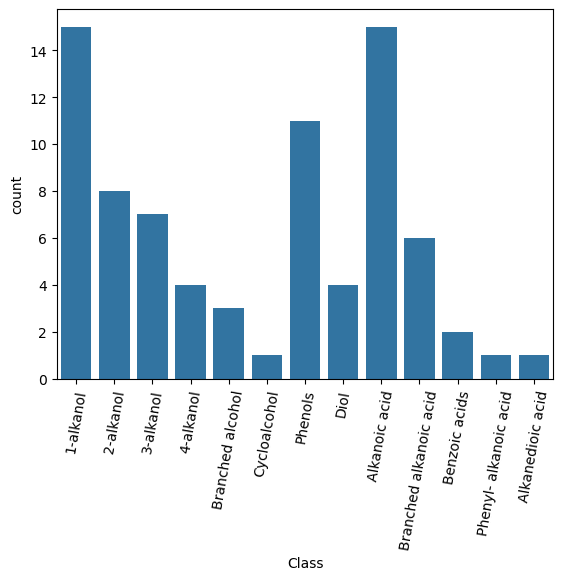

In [246]:
# A countplot (bar chart) can be used to visualise the frequency of compounds in each class.

sns.countplot(data=cdf, x="Class")
plt.xticks(rotation=80)

plt.show()

Alcohols comprise the majority of the dataset, with 1-alkanols (primary alkane diols) being the major class. Of the acids, alkane-derived carboxylic acids are the main group. There are three classes containing only a single compound - cyclic alcohols, phenyl-alkanoic acid and alkanedioic (i.e. alkane dicarboxylic) acids. It is important to bear in mind that some classes are poorly represented and which classes will strong influence due to the frequency they occur in the dataset. 

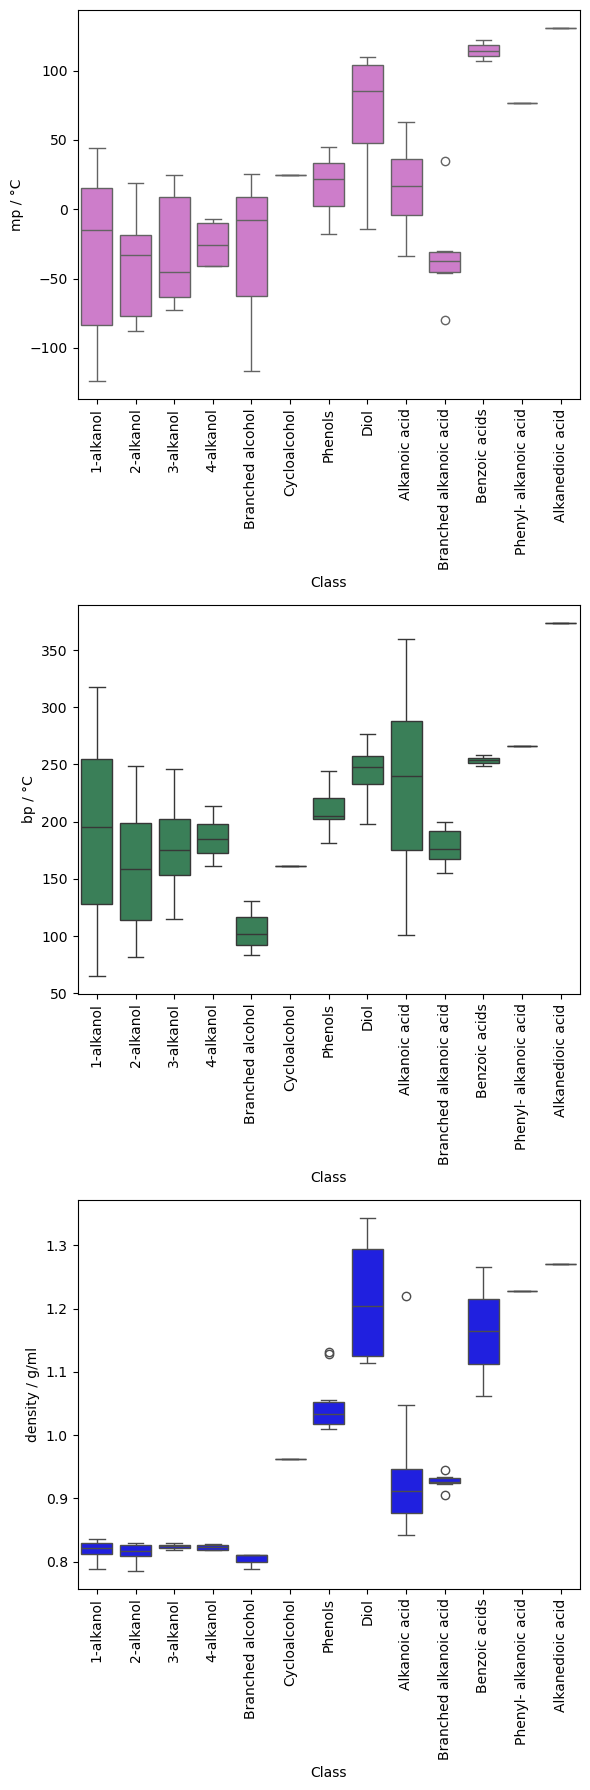

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 18), sharex=False)

y_cols = ["mp / °C", "bp / °C", "density / g/ml"]
colours = ["orchid", "seagreen", "blue"]


for i, col in enumerate(y_cols):
#    sns.histplot(data=cdf, x=col, ax=axs[i], color=colours[i])

   g = sns.boxplot(data=cdf, x="Class", y=col, ax=axs[i], color=colours[i])
   labels = g.get_xticklabels()
   g.set_xticks(range(0, len(labels)))
   g.set_xticklabels(g.get_xticklabels(), rotation=90)


plt.tight_layout()
plt.show()

The boxplots suggest that there may be some values that further warrant investigation to check their validity. However, many of the classes contain relatively few samples, so analysis of the distribution based on the standard deviation is unlikely to be very reliable.

The largest classes show quite wide variation in their phase change temperatures, with no values appearing to be statistically unusual. Looking at the compounds, the range of melting and boiling points seems fairly reasonable given the compositional range.

Can you think of a way to visualise the variation in mp and/or boiling point within these classes as a function of composition?

In [401]:
major_classes = cdf[cdf["Class"].isin(["1-alkanol", "Alkanoic acid"])]

value_vars=["mp / °C", "bp / °C", "#C"]
data=major_classes.melt(value_vars=value_vars, id_vars=["Class", "#C"])
data

,Class,#C,variable,value
0,1-alkanol,1,mp / °C,-98.0
1,1-alkanol,2,mp / °C,-114.0
2,1-alkanol,3,mp / °C,-124.0
3,1-alkanol,4,mp / °C,-89.0
4,1-alkanol,5,mp / °C,-78.0
5,1-alkanol,6,mp / °C,-46.0
6,1-alkanol,7,mp / °C,-33.0
7,1-alkanol,8,mp / °C,-15.0
8,1-alkanol,9,mp / °C,-5.0
9,1-alkanol,10,mp / °C,7.0


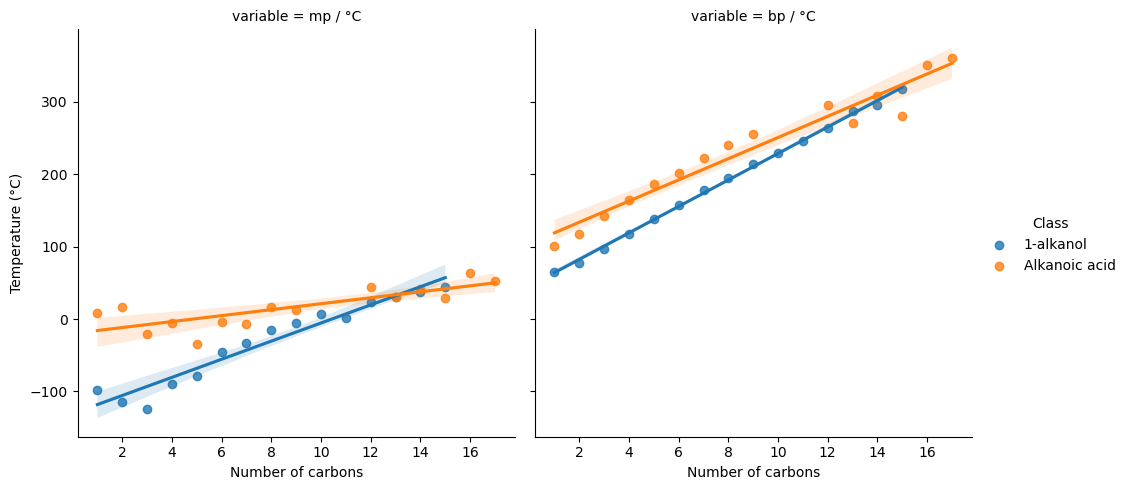

In [403]:
g = sns.lmplot(data=data, x="#C", y="value", hue="Class", col="variable", fit_reg=True)

g.set_axis_labels("Number of carbons", "Temperature (°C)")

plt.show()

In [414]:
cdf.drop(columns=["Class", "IUPAC name"]).corr()

,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml
#C,1.000000,0.905225,0.014530,0.984666,0.490628,0.842080,-0.173112
#H,0.905225,1.000000,-0.114922,0.896220,0.196345,0.624951,-0.500815
#O,0.014530,-0.114922,1.000000,0.176808,0.461976,0.431204,0.591196
Molweight g/mol,0.984666,0.896220,0.176808,1.000000,0.527376,0.884174,-0.115906
mp / °C,0.490628,0.196345,0.461976,0.527376,1.000000,0.741620,0.624396
bp / °C,0.842080,0.624951,0.431204,0.884174,0.741620,1.000000,0.296797
density / g/ml,-0.173112,-0.500815,0.591196,-0.115906,0.624396,0.296797,1.000000


Seaborn's [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function can be used to visualise the relationships between the numerical columns in a dataframe. The hue parameter can be used to colour the points by a categorical column.

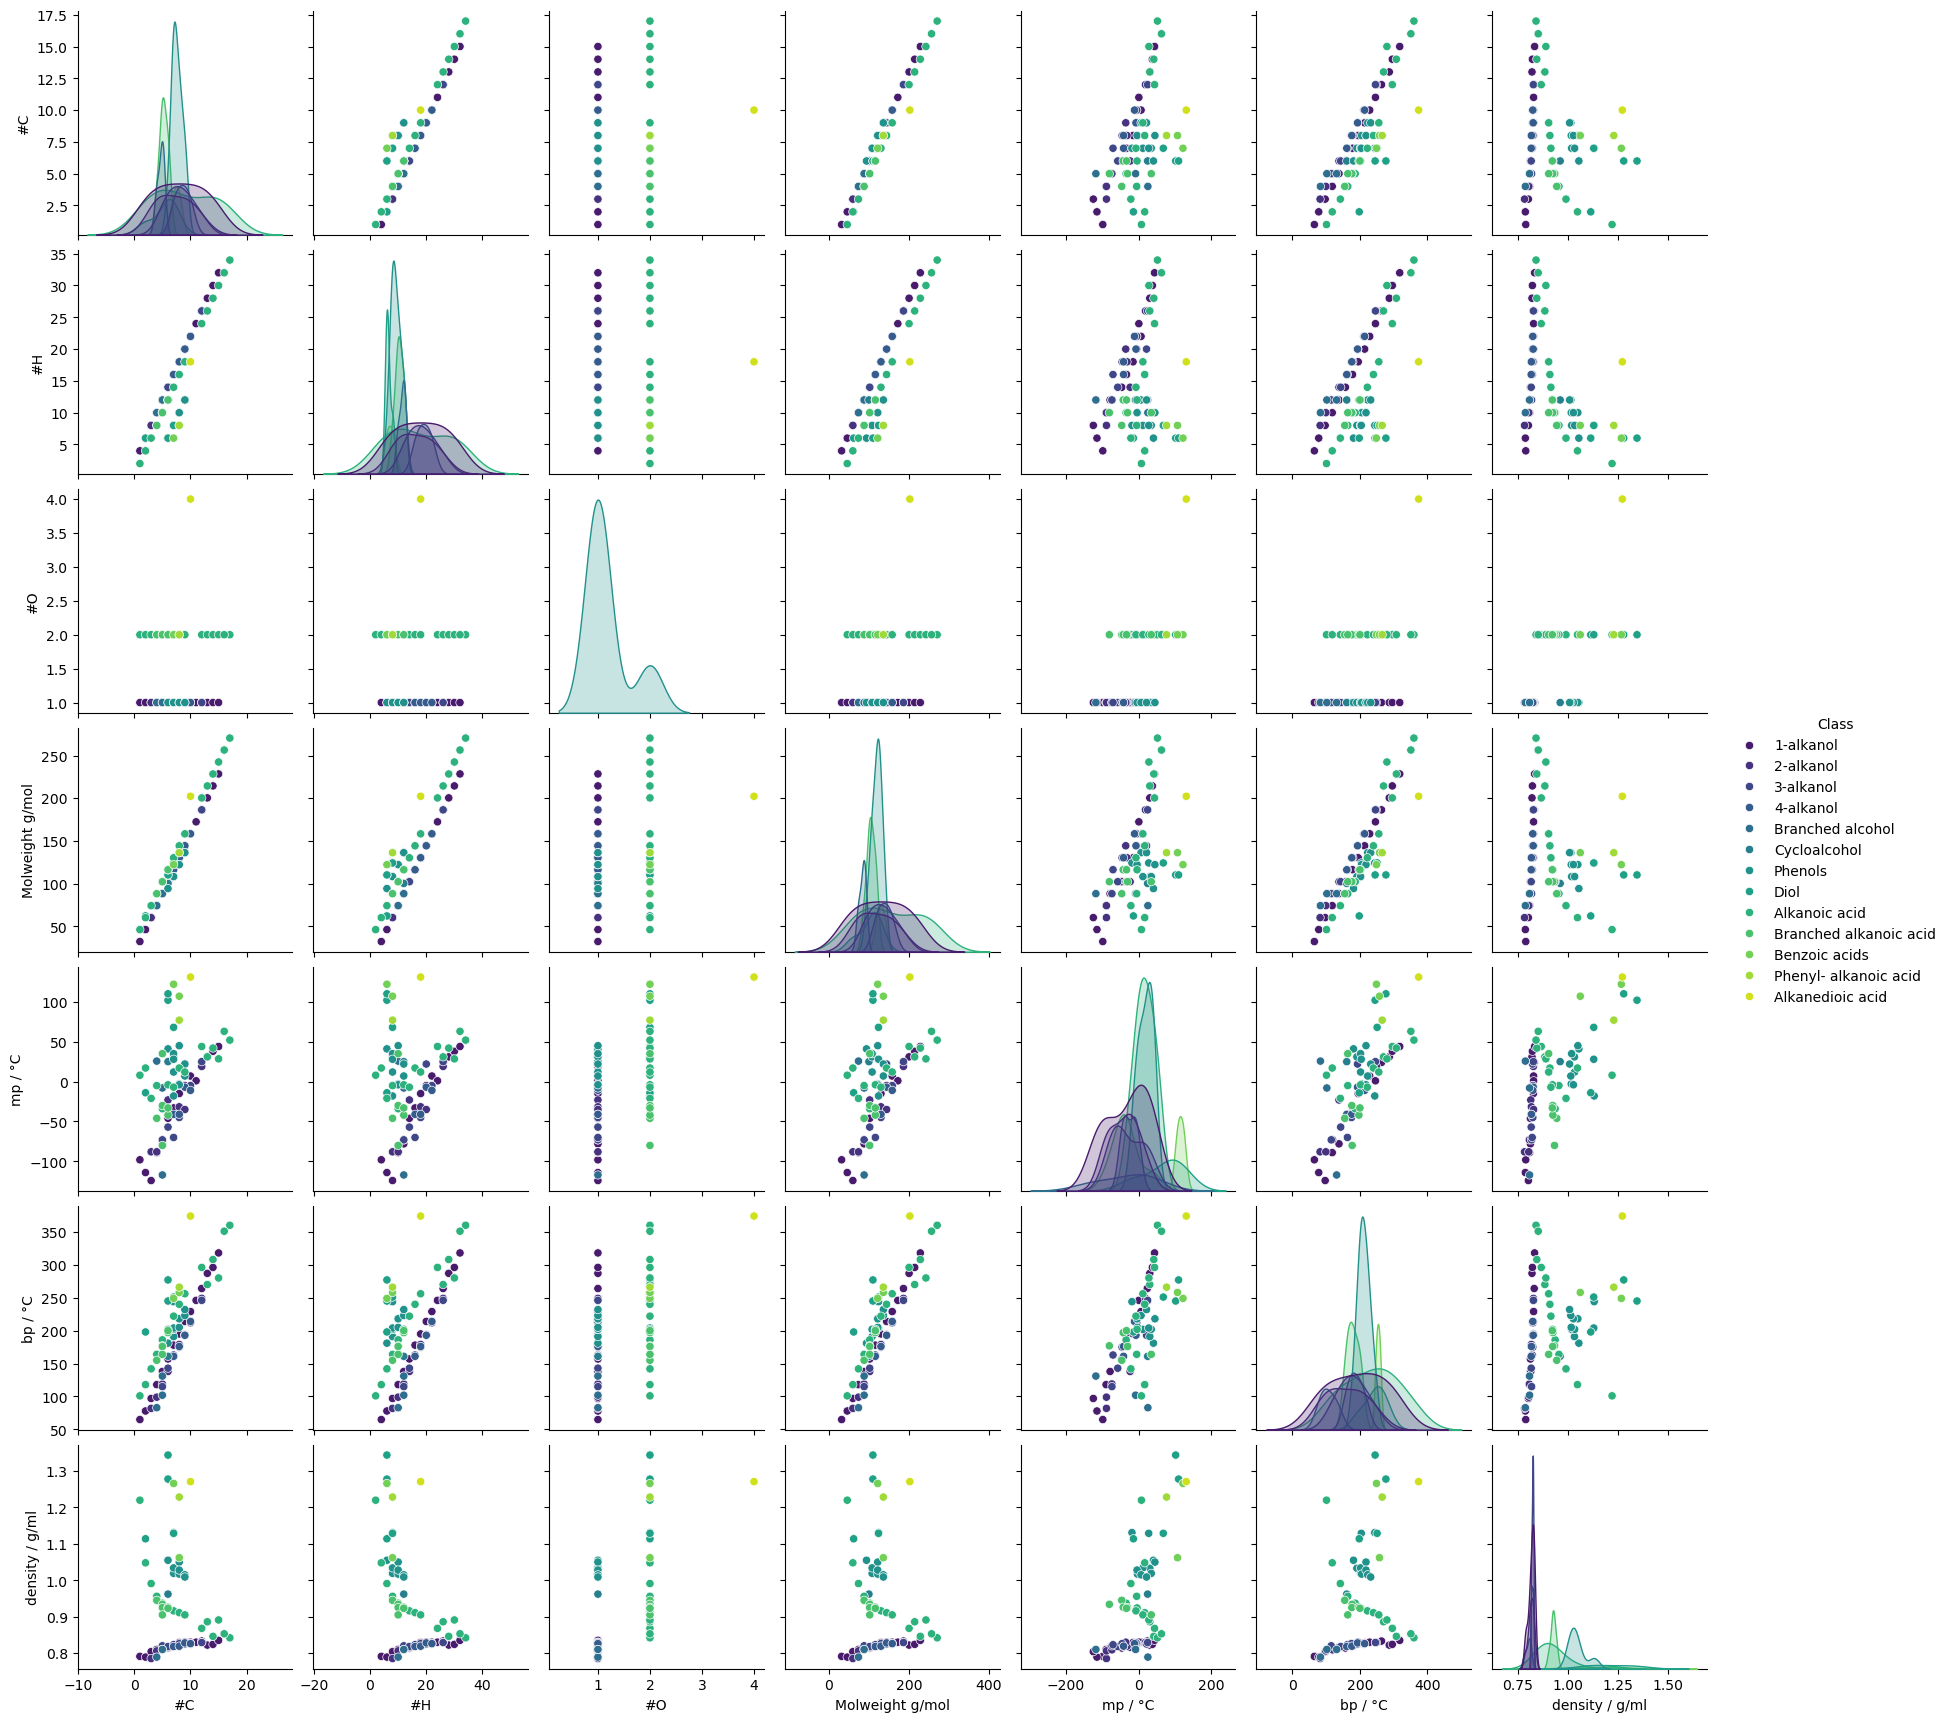

In [405]:
sns.pairplot(cdf, hue="Class", diag_kind="kde",  palette="viridis")
plt.show()

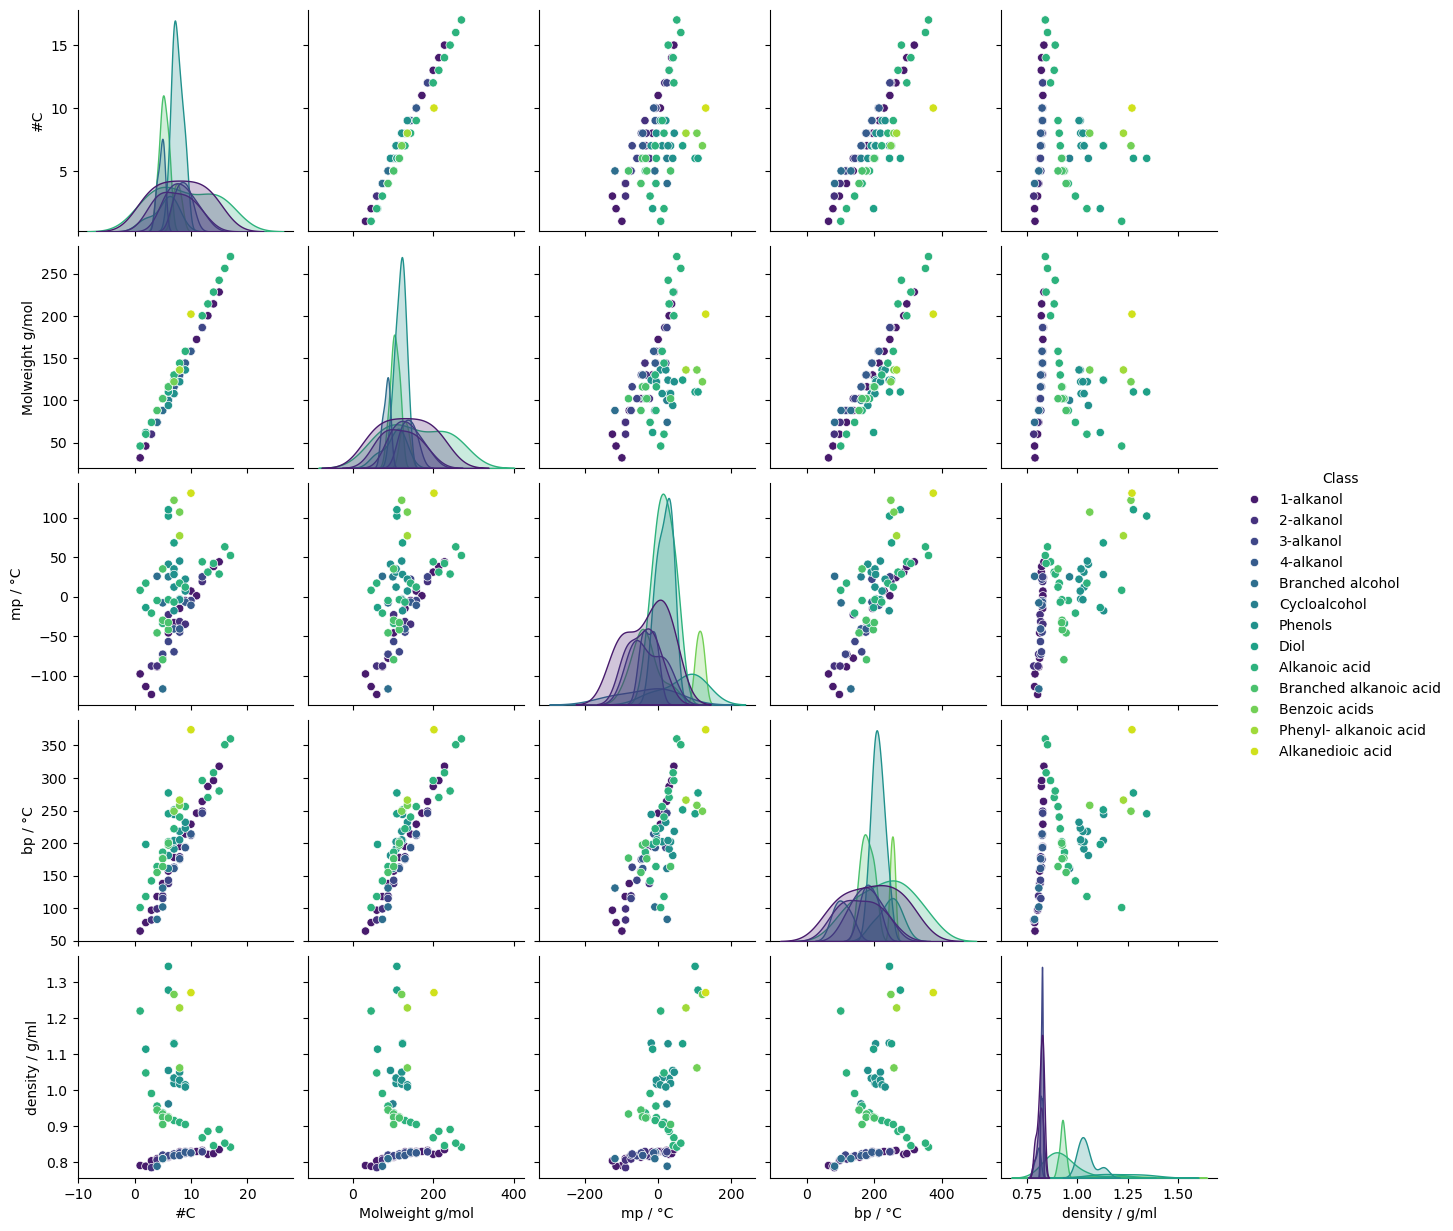

In [456]:
# The plot is quite crowded. Redraw the pair plot with a smaller subset of the data. Dropping #O 
# (only two unique values, no relation to others) and #H atoms (strongly correlated with #C) will 
# reduce the number of dimensions.

drop_cols = ["#O", "#H"]

df = cdf.drop(columns=drop_cols)

sns.pairplot(df, hue="Class", diag_kind="kde",  palette="viridis")
plt.show()

An alternative way to look for correlations between numerical variables is using a heatmap. These can be annotated with a correlation coefficient.

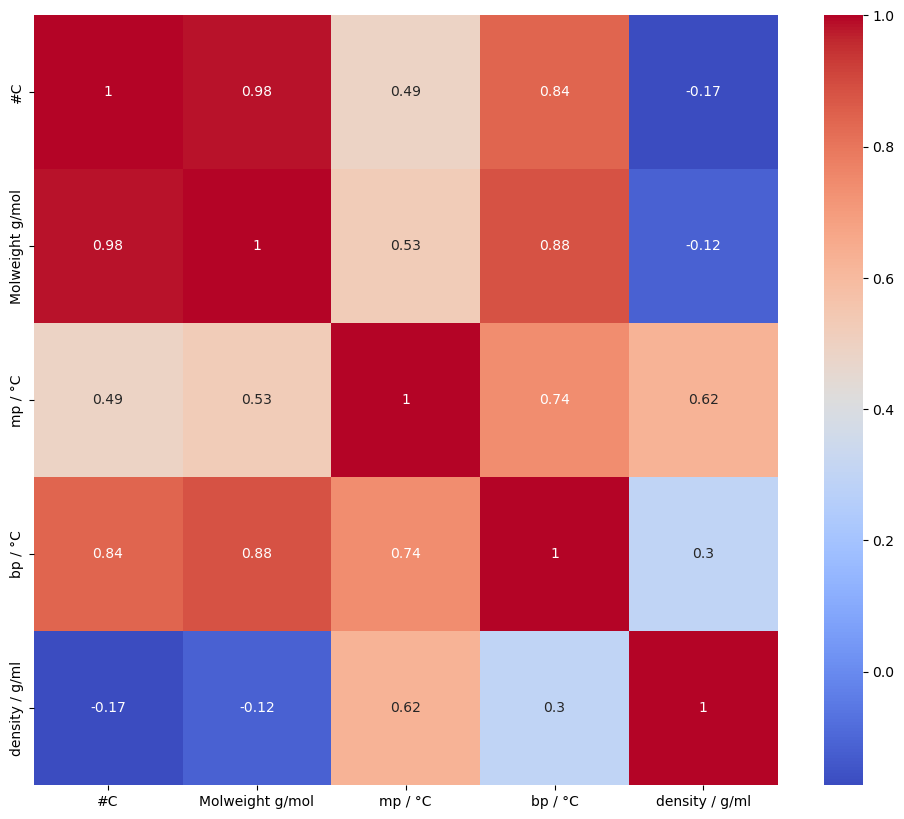

In [457]:
# The correlation matrix can be visualised using a heatmap. The annot parameter adds the
# correlation values to the plot. By default, these are the Pearson correlation coefficient.

sns.heatmap(df.drop(columns=["Class", "IUPAC name"]).corr(), annot=True, cmap="coolwarm")
plt.show()

As we would expect, there is clearly a strong relationship between molecular weight and boiling point; and a weaker positive correlation with melting point.

Molecular weight and the number of carbons are also strongly correlated - again, this is intuitive. The correlation is so strong that one is essentially redundant. [If the data was going to be used to fit a model, it would be advisable to remove one of these features to reduce model complexity and avoid possible issues with colinear features.]

The combination of scatterplots and heatmap shows some interesting class-related effects. The relationship between density and other variables, for example, is quite different depending on the compound's class. Over the whole dataset, the correlation coefficient between density and boiling point is 0.3, indicating only a weak positive correlation, but the pairplot suggests stronger, but distinct correlations within some classes.

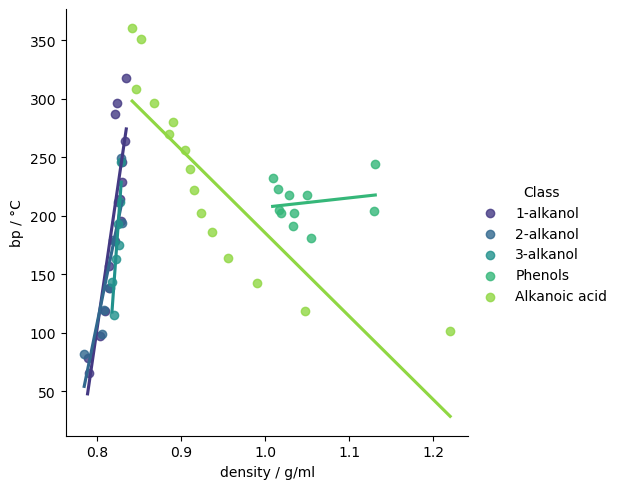

In [ ]:
# To see the relationship between density and boiling point more clearly, we can plot a
# scatterplot restricted to the 5 largest classes (>= 7 or more samples).

top_classes = cdf["Class"].value_counts()[:5].index.to_list()

df = cdf[cdf["Class"].isin(top_classes)]
sns.lmplot(df, x="density / g/ml", y="bp / °C", hue="Class", fit_reg=True,  ci=None, palette="viridis")
plt.show()

### Adding some descriptors

We have a list of compounds and a small number of observed values and descriptors. We can add a few more by calculating them using RDKit, but we only have IUPAC names, so we need to obtain a more rigorous representation to use with RDKit.


#### Get some SMILES strings

The [Chemical Identifier Resolver](https://cactus.nci.nih.gov/chemical/structure) (CIR) service is run by the CADD Group at the NCI/NIH as part of their [Cactus server](https://cactus.nci.nih.gov). It is used in the [Molecular fingerprints notebook](https://drsamchong.github.io/c3d-book/1-chem_data/fingerprints.html).

In [129]:
# Here is a function so the process of getting the SMILES can be repeated for multiple compounds.
# It includes a sleep time (`time.sleep`) to avoid overloading the server.

def get_smiles_from_name(name):
    """Gets SMILES string from the Cactus API given a chemical name."""
    
    ROOT_URL = "https://cactus.nci.nih.gov/chemical/structure/"
    identifier = name
    representation = "smiles"

    query_url = f"{ROOT_URL}{identifier}/{representation}"

    response = requests.get(query_url)
    time.sleep(0.05)
    if response:
        return response.text
    else:
        print(f"Failed to get SMILES for {name}")
        return "not found"
        # raise Exception(f"Cactus request failed for {name}: {response.status_code}")


In [130]:
# TODO: Get a list of SMILES strings for the compounds in the dataframe and add this to the 
# dataframe as a new column.

compounds = cdf["IUPAC name"]

smiles = [get_smiles_from_name(compound) for compound in compounds]
# This can take > 1 minute to run
smiles

Failed to get SMILES for Pentacanoic acid


['CO',
 'CCO',
 'CCCO',
 'CCCCO',
 'CCCCCO',
 'CCCCCCO',
 'CCCCCCCO',
 'CCCCCCCCO',
 'CCCCCCCCCO',
 'CCCCCCCCCCO',
 'CCCCCCCCCCCO',
 'CCCCCCCCCCCCO',
 'CCCCCCCCCCCCCO',
 'CCCCCCCCCCCCCCO',
 'CCCCCCCCCCCCCCCO',
 'CC(C)O',
 'CCC(C)O',
 'CCCC(C)O',
 'CCCCC(C)O',
 'CCCCCCC(C)O',
 'CCCCCCCC(C)O',
 'CCCCCCCCC(C)O',
 'CCCCCCCCCCC(C)O',
 'CCC(O)CC',
 'CCCC(O)CC',
 'CCCCC(O)CC',
 'CCCCCC(O)CC',
 'CCCCCCC(O)CC',
 'CCCCCCCC(O)CC',
 'CCCCCCCCCC(O)CC',
 'CCCC(O)CCC',
 'CCCCC(O)CCC',
 'CCCCCC(O)CCC',
 'CCCCCCC(O)CCC',
 'CC(C)(C)O',
 'CCC(C)(C)O',
 'CC(C)CCO',
 'OC1CCCCC1',
 'Oc1ccccc1',
 'Cc1ccccc1O',
 'Cc1ccc(O)cc1',
 'Cc1cccc(O)c1',
 'COc1ccccc1O',
 'COc1cccc(O)c1',
 'CCc1ccccc1O',
 'CCc1ccc(O)cc1',
 'CCc1cccc(O)c1',
 'CCCc1ccccc1O',
 'CCCc1ccc(O)cc1',
 'OCCO',
 'Oc1ccccc1O',
 'Oc1cccc(O)c1',
 'Cc1ccc(O)c(O)c1',
 'OC=O',
 'CC(O)=O',
 'CCC(O)=O',
 'CCCC(O)=O',
 'CCCCC(O)=O',
 'CCCCCC(O)=O',
 'CCCCCCC(O)=O',
 'CCCCCCCC(O)=O',
 'CCCCCCCCC(O)=O',
 'CCCCCCCCCCCC(O)=O',
 'CCCCCCCCCC(O)=O',
 'CCCCCCCCCCC

In [132]:
# add the SMILES column to the dataframe
cdf.loc[:,"SMILES"] = smiles
cdf

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,SMILES
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.7910,CO
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.7890,CCO
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.8040,CCCO
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.8100,CCCCO
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.8140,CCCCCO
...,...,...,...,...,...,...,...,...,...,...
85,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200.0,0.9230,CC(C)CCC(O)=O
89,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249.0,1.2660,OC(=O)c1ccccc1
90,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258.0,1.0620,Cc1ccccc1C(O)=O
97,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266.0,1.2286,OC(=O)Cc1ccccc1


In [ ]:
# cdf.to_csv("data/alcohol_acid_phys_data_cleaned.csv", index=False)

Let's generate some descriptors for these molecules using RDKit.

There is a [tutorial](https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html) on calculating descriptors, and they are listed in the [Getting Started guide](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors).

There are two main stages:

1. Create RDKit molecules
2. Calculate descriptors

RDKit needs a `RDKit.molecule` to calculate the descriptors. You can create a separate list of molecules based on the SMILES strings in the dataframe, or you can use RDKit's [PandasTools module](https://www.rdkit.org/docs/source/rdkit.Chem.PandasTools.html) to work with them in a DataFrame.

Have a look at the [molecular fingerprints notebook](https://drsamchong.github.io/c3d-book/1-chem_data/fingerprints.html) for some code to get started getting the RDKit molecules.

- Choose around 5 additional descriptors to calculate for each compound.
- It is up to you how you handle the calculations and getting the new data combined with the existing dataframe. 

Here is one option:

- You could use the getMolDescriptors function in the [descriptors tutorial](https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html) as starting point to calculate the new descriptors and add them to dictionary that can be read into a dataframe.
- You can then use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to combine the dataframe with your thermochemical data with the new descriptors.

In [152]:
# To be safe, you can create a new dataframe. This will allow you to start from this point.

mols_df = cdf.copy()

# Drop the row for the compound whose SMILES string was not found on the server and reset the index.

mols_df = mols_df[mols_df["SMILES"] != "not found"].reset_index(drop=True)
mols_df


,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,SMILES
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.7910,CO
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.7890,CCO
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.8040,CCCO
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.8100,CCCCO
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.8140,CCCCCO
...,...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200.0,0.9230,CC(C)CCC(O)=O
73,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249.0,1.2660,OC(=O)c1ccccc1
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258.0,1.0620,Cc1ccccc1C(O)=O
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266.0,1.2286,OC(=O)Cc1ccccc1


,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,SMILES,ROMol
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.7910,CO,
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.7890,CCO,
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.8040,CCCO,
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.8100,CCCCO,
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.8140,CCCCCO,
...,...,...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200.0,0.9230,CC(C)CCC(O)=O,
73,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249.0,1.2660,OC(=O)c1ccccc1,
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258.0,1.0620,Cc1ccccc1C(O)=O,
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266.0,1.2286,OC(=O)Cc1ccccc1,

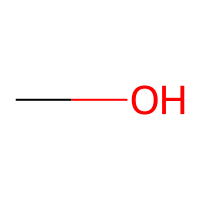
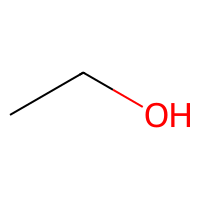
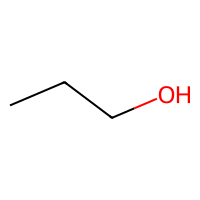
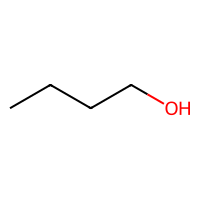
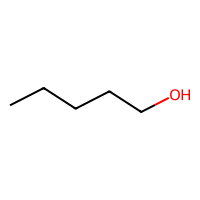
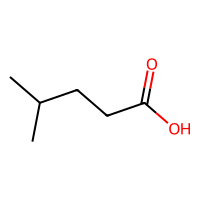
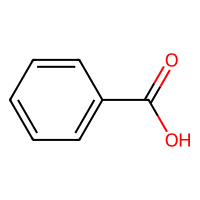
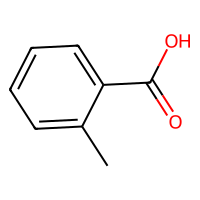
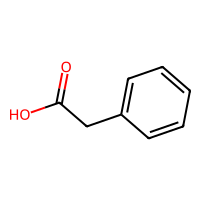
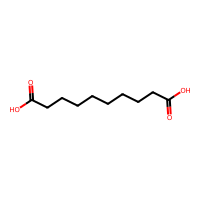

In [ ]:
# Add RDKit molecule objects to the dataframe. This code uses the PandasTools module from RDKit.

PandasTools.AddMoleculeColumnToFrame(mols_df, smilesCol="SMILES")
mols_df

In [154]:
# This code lists the available descriptors in RDKit. The first column is the index of the
# descriptor. This will be useful for selecting descriptors to calculate.
for idx, desc in enumerate(Descriptors.descList):
    print(f"{idx} {desc[0]}")

0 MaxAbsEStateIndex
1 MaxEStateIndex
2 MinAbsEStateIndex
3 MinEStateIndex
4 qed
5 SPS
6 MolWt
7 HeavyAtomMolWt
8 ExactMolWt
9 NumValenceElectrons
10 NumRadicalElectrons
11 MaxPartialCharge
12 MinPartialCharge
13 MaxAbsPartialCharge
14 MinAbsPartialCharge
15 FpDensityMorgan1
16 FpDensityMorgan2
17 FpDensityMorgan3
18 BCUT2D_MWHI
19 BCUT2D_MWLOW
20 BCUT2D_CHGHI
21 BCUT2D_CHGLO
22 BCUT2D_LOGPHI
23 BCUT2D_LOGPLOW
24 BCUT2D_MRHI
25 BCUT2D_MRLOW
26 AvgIpc
27 BalabanJ
28 BertzCT
29 Chi0
30 Chi0n
31 Chi0v
32 Chi1
33 Chi1n
34 Chi1v
35 Chi2n
36 Chi2v
37 Chi3n
38 Chi3v
39 Chi4n
40 Chi4v
41 HallKierAlpha
42 Ipc
43 Kappa1
44 Kappa2
45 Kappa3
46 LabuteASA
47 PEOE_VSA1
48 PEOE_VSA10
49 PEOE_VSA11
50 PEOE_VSA12
51 PEOE_VSA13
52 PEOE_VSA14
53 PEOE_VSA2
54 PEOE_VSA3
55 PEOE_VSA4
56 PEOE_VSA5
57 PEOE_VSA6
58 PEOE_VSA7
59 PEOE_VSA8
60 PEOE_VSA9
61 SMR_VSA1
62 SMR_VSA10
63 SMR_VSA2
64 SMR_VSA3
65 SMR_VSA4
66 SMR_VSA5
67 SMR_VSA6
68 SMR_VSA7
69 SMR_VSA8
70 SMR_VSA9
71 SlogP_VSA1
72 SlogP_VSA10
73 SlogP_VSA1

In [458]:
# Adapted from https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html

def getMolDescriptors(mol, descriptor_list=None, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    if not(descriptor_list):
        descriptors = Descriptors._descList
    # TODO: Add else clause to handle a list numbers corresponding to the descriptor indices
    else:
        descriptors = [Descriptors._descList[idx] for idx in descriptor_list]

    for nm,fn in descriptors:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [ ]:
# These are the descriptors selected to calculate for the molecules.
# 118 NumHAcceptors
# 119 NumHDonors
# 27 BalabanJ - a topological descriptor expressing molecular connectivity and branching
# 28 BertzCT - a topological complexity index
# 83 TPSA - total polar surface area

descriptor_list = [118, 119, 27, 28, 83]


calc_descriptors = [getMolDescriptors(mol, descriptor_list=descriptor_list) for mol in mols_df["ROMol"]]

# Create a dataframe from the calculated descriptors
descriptor_df = pd.DataFrame(calc_descriptors)



In [460]:
# TODO: Add the descriptors to the dataframe as new columns

mols_df = pd.concat([mols_df, descriptor_df], axis=1)
mols_df


,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / °C,bp / °C,density / g/ml,SMILES,...,NumHAcceptors,NumHDonors,BalabanJ,BertzCT,TPSA,NumHAcceptors,NumHDonors,BalabanJ,BertzCT,TPSA
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65.0,0.7910,CO,...,1,1,1.000000,2.000000,20.23,1,1,1.000000,2.000000,20.23
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78.0,0.7890,CCO,...,1,1,1.632993,2.754888,20.23,1,1,1.632993,2.754888,20.23
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97.0,0.8040,CCCO,...,1,1,1.974745,5.245112,20.23,1,1,1.974745,5.245112,20.23
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118.0,0.8100,CCCCO,...,1,1,2.190610,11.119415,20.23,1,1,2.190610,11.119415,20.23
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138.0,0.8140,CCCCCO,...,1,1,2.339092,15.900135,20.23,1,1,2.339092,15.900135,20.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200.0,0.9230,CC(C)CCC(O)=O,...,1,1,3.050078,76.597721,37.30,1,1,3.050078,76.597721,37.30
73,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249.0,1.2660,OC(=O)c1ccccc1,...,1,1,2.981455,203.415953,37.30,1,1,2.981455,203.415953,37.30
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258.0,1.0620,Cc1ccccc1C(O)=O,...,1,1,3.152941,253.189433,37.30,1,1,3.152941,253.189433,37.30
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266.0,1.2286,OC(=O)Cc1ccccc1,...,1,1,2.674242,215.959017,37.30,1,1,2.674242,215.959017,37.30


### Back to visualisation

Using your new seaborn skills, visualise the distributions and identify any correlations in your new data.

You will probably find plots like pairplots or heatmaps of more use now that you have a few more variables.


### Summary

- You have used the pandas library to clean and prepare a dataset, and to get descriptive statistics for the data.

- You have visualised distributions and relationships in the data to look for anomalies and patterns.

- You have used an API to obtain molecular identifiers/representations for a set of compounds.

- You have generated molecular descriptors for a set of compounds using RDKit.

